## Experiments with PageRank

In [1]:
import matplotlib.pyplot as plt
import networkit as nk
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from fast_pagerank import pagerank
from fast_pagerank import pagerank_power
from scipy import sparse
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import rbf_kernel, cosine_similarity
from tqdm import tqdm

import utils

In [2]:
# Load data
df_data = pd.read_csv('../data/ice-cat-office-products.csv.gz', dtype=str, index_col=0)

# Filter out small product categories
# top_categories = utils.find_top_n_categories(df_data, top_n=10)
top_categories = [
#     'Folders',                         # N=645
#     'Self-Adhesive Labels',            # N=324
#     'Multimedia Carts & Stands',       # N=317
#     'Calculators',                     # N=305
#     'Writing Notebooks'                # N=300
#     'Ring Binders',                    # N=298
#     'Printer Cabinets & Stands',       # N=252
    'Whiteboards',                     # N=232
#    'Fax Machines',                    # N=210
    'File Storage Boxes'               # N=192
]
df_data = df_data[df_data.category_name.isin(top_categories)]

# Sort by category for later visualisation
df_data.sort_values('category_name', inplace=True)

product_features = utils.get_product_feature_columns_for_training(df_data)
df_play_data = df_data[['category_name'] + product_features].copy()

In [3]:
df_data.category_name.value_counts()

Whiteboards           232
File Storage Boxes    192
Name: category_name, dtype: int64

In [4]:
X = utils.preprocess_dataframe(df_play_data)
X.shape

(424, 171)

In [5]:
# Reduce to number of dimensions so the remaining dimensions
# explain at least 90 percent of the variance.
svd = PCA(n_components=0.9, random_state=42)
X_transformed = svd.fit_transform(X)
X_transformed.shape

(424, 19)

In [6]:
similarity_matrix = cosine_similarity(X)

# Ensure similarity matrix entries are normalised in the range [0,1]
similarity_matrix = (similarity_matrix - np.min(similarity_matrix)) / np.ptp(similarity_matrix)

In [7]:
np.min(similarity_matrix), np.max(similarity_matrix)

(0.0, 1.0)

<AxesSubplot:>

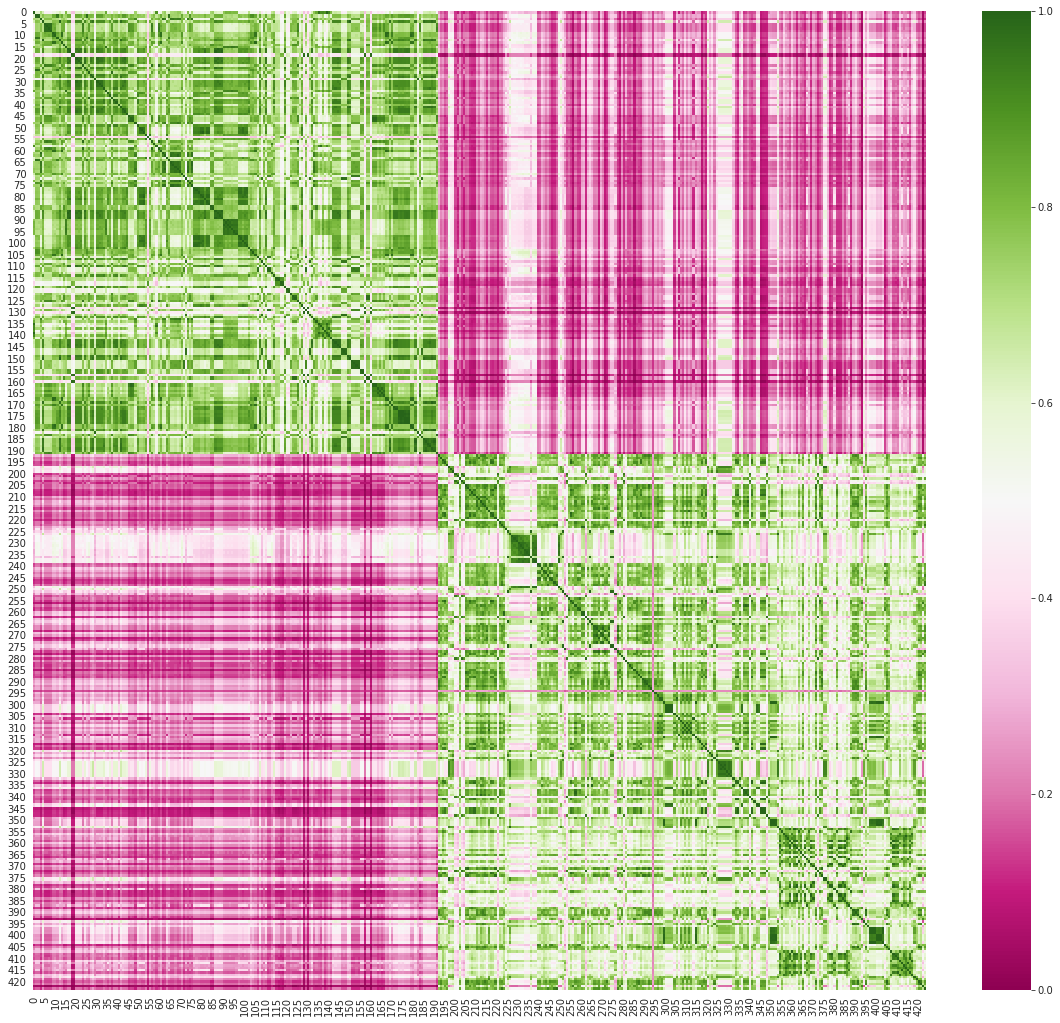

In [8]:
# similarity_matrix = rbf_kernel(X_transformed)
fig, ax = plt.subplots(figsize=(20, 18))
sns.heatmap(similarity_matrix, cmap="PiYG", ax=ax)

## Community Detection

In [9]:
g = nk.Graph(weighted=True, directed=False)

n = similarity_matrix.shape[0]
g.addNodes(n)
for i in range(n):
    for j in range(i, n):
        if i != j:
            g.addEdge(i, j, similarity_matrix[i, j])

In [10]:
communities = nk.community.detectCommunities(g)

PLM(balanced,pc,turbo) detected communities in 0.002521514892578125 [s]
solution properties:
-------------------  ----------
# communities          2
min community size   192
max community size   232
avg. community size  212
modularity             0.221413
-------------------  ----------


In [11]:
nk.community.Modularity().getQuality(communities, g)

0.22141288220609567

## Personalised PageRank

In [12]:
weighted_graph = nx.from_numpy_matrix(similarity_matrix)

In [ ]:
df_data_fixed_index = df_play_data.reset_index()
n_rows = df_data_fixed_index.shape[0]


rankings = []

for i in tqdm(range(n_rows)):
    cat = df_data_fixed_index.iloc[i].category_name
    product_indices = list(df_data_fixed_index[df_data_fixed_index.category_name == cat].index)
    sampled_indices = np.random.choice(product_indices, size=10)
    n_cat = len(sampled_indices)
    personalisation = {i: 1/n_cat for i in sampled_indices}
    ppr = nx.pagerank(weighted_graph, personalization=personalisation)
    # sorted_ranking = {k: v for k, v in sorted(ppr.items(), key=lambda item: item[1], reverse=True)}
    sorted_ranking = [k for k, v in sorted(ppr.items(), key=lambda item: item[1], reverse=True)]
    rankings.append(sorted_ranking)

  0%|          | 2/424 [00:04<16:24,  2.33s/it]